<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 3</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

## 1. Visualize & preprocess

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt, welch
from scipy.ndimage import convolve1d

np.random.seed(42)
random_state = 42

# Paths + results directory
data_folder_name = "Data"
subject_folder_name = "Dataset8"
subject_data_name = "S1_E1_A1.mat"
subject_data_path = os.path.join(data_folder_name, subject_folder_name, subject_data_name)

out_dir = os.path.join(os.getcwd(), "Results", "Part3")
os.makedirs(out_dir, exist_ok=True)

# Load data
data = loadmat(subject_data_path)

emg        = data["emg"]                    # (T, n_channels)
restimulus = data["restimulus"].ravel()     # corrected labels, 1D
rerepetition  = data["rerepetition"].ravel()  # repetition indices, 1D

print("EMG shape:", emg.shape, "| dtype:", emg.dtype)
print("Glove shape:", data["glove"].shape)
print("Unique restimulus:", np.unique(restimulus))
print("Unique rerepetition:", np.unique(rerepetition))

# Select movement-only rows
movement_mask = (restimulus > 0)
row_indices = np.where(movement_mask)[0]

emg_mov = emg[movement_mask, :]  # movement-only EMG

# Joint angles to use (per assignment)
joint_angles_used = [3, 6, 8, 11, 14]
glove_mov = data["glove"][row_indices, :][:, joint_angles_used]  # (T_mov, 5)

print("Movement-only EMG:", emg_mov.shape)
print("Movement-only glove:", glove_mov.shape)

# NinaPro DB1 EMG sampling freq
fs = 100  # Hz

EMG shape: (2292526, 16) | dtype: float32
Glove shape: (2292526, 18)
Unique restimulus: [0 1 2 3 4 5 6 7 8 9]
Unique rerepetition: [ 0  1  2  3  4  5  6  7  8  9 10]
Movement-only EMG: (1104351, 16)
Movement-only glove: (1104351, 5)


### Quick visualizations

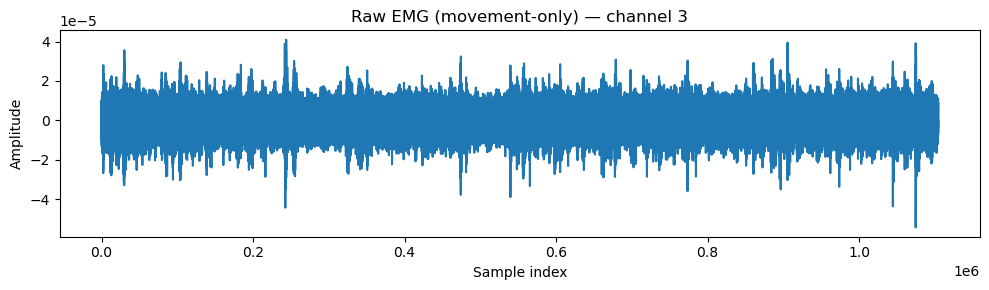

In [ ]:
# Raw EMG channel snippet
plt.close("all")
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(emg_mov[:, 3])
ax.set_title("Raw EMG (movement-only) — channel 3")
ax.set_xlabel("Sample index")
ax.set_ylabel("Amplitude")
fig.tight_layout()
fig.savefig(os.path.join(out_dir, "raw_emg_channel3.png"), dpi=200)

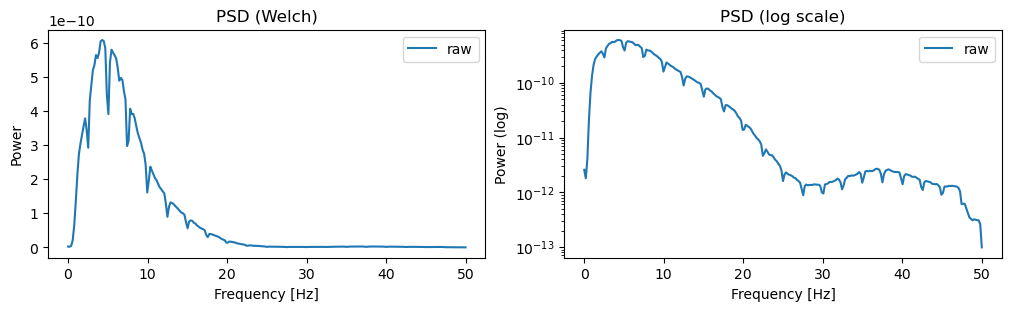

In [ ]:
# PSD (Welch) on a raw channel
freqs_pre, Pxx_pre = welch(emg_mov[:, 8], fs=fs, nperseg=512)
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].set_title("PSD (Welch)")
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power")
ax[0].legend()

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].set_title("PSD (log scale)")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power (log)")
ax[1].legend()

fig.savefig(os.path.join(out_dir, "psd_raw_channel8.png"), dpi=200)

### Preprocesssing

In [ ]:
def bandpass_emg(emg_in, fs, bp=(5, 45), order=4):
    sos = butter(order, bp, btype="bandpass", fs=fs, output="sos")
    return sosfiltfilt(sos, emg_in, axis=0)

def rectified_envelope(emg_filt, window_samples=25):
    # 25 samples @ 100 Hz = 250 ms
    emg_rect = np.abs(emg_filt)
    w = np.ones(window_samples) / window_samples
    return convolve1d(emg_rect, w, axis=0, mode="nearest")

emg_filt = bandpass_emg(emg_mov, fs=fs, bp=(5, 45), order=4)
emg_env  = rectified_envelope(emg_filt, window_samples=25)

print("Envelope shape:", emg_env.shape)

Envelope shape: (1104351, 16)


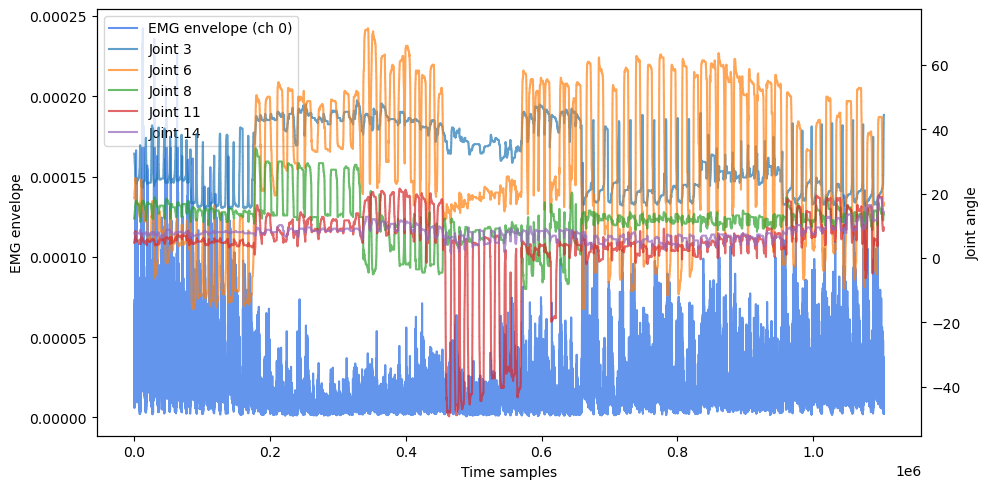

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# EMG envelope
ax.plot(emg_env[:, 0], color="cornflowerblue", label="EMG envelope (ch 0)")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

# Joint angles (one or several, explicitly labeled)
finger_angle_ax = ax.twinx()
for i, j in enumerate(joint_angles_used):
    finger_angle_ax.plot(
        glove_mov[:, i],
        label=f"Joint {j}",
        alpha=0.7
    )
finger_angle_ax.set_ylabel("Joint angle")
finger_angle_ax.grid(False)

# Combined legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = finger_angle_ax.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()

# Save figure
out_dir = os.path.join(os.getcwd(), "Results", "Part3")
os.makedirs(out_dir, exist_ok=True)
fig.savefig(
    os.path.join(out_dir, "emg_envelope_vs_joint_angles.png"),
    dpi=200,
    bbox_inches="tight"
)


### Time-series split

In [ ]:
n = emg_env.shape[0]
i1 = int(0.6 * n)
i2 = int(0.8 * n)

EMG_train, EMG_val, EMG_test = emg_env[:i1], emg_env[i1:i2], emg_env[i2:]
Y_train,   Y_val,   Y_test   = glove_mov[:i1], glove_mov[i1:i2], glove_mov[i2:]

print(f"Train: EMG {EMG_train.shape} | Y {Y_train.shape}")
print(f"Val:   EMG {EMG_val.shape}   | Y {Y_val.shape}")
print(f"Test:  EMG {EMG_test.shape}  | Y {Y_test.shape}")

Train: EMG (662610, 16) | Y (662610, 5)
Val:   EMG (220870, 16)   | Y (220870, 5)
Test:  EMG (220871, 16)  | Y (220871, 5)


## 2. Sliding windows

In [ ]:
emg_window_length_sec = 0.200   # 200 ms
window_step_sec       = 0.040   # 40 ms

print("Window length [s]:", emg_window_length_sec, "| step [s]:", window_step_sec)

Window length [s]: 0.2 | step [s]: 0.04


In [ ]:
def extract_time_windows_regression(
    EMG: np.ndarray,
    Y: np.ndarray,
    fs: int,
    win_len_sec: float,
    step_sec: float,
):
    """
    Extract overlapping sliding windows for regression.

    Parameters
    ----------
    EMG : array, shape (T, n_channels)
        Preprocessed EMG envelope.
    Y : array, shape (T, n_outputs)
        Continuous targets (joint angles).
    fs : int
        Sampling frequency (Hz).
    win_len_sec : float
        Window length in seconds.
    step_sec : float
        Step size between windows in seconds.

    Returns
    -------
    EMG_windows : array, shape (n_windows, win_len, n_channels)
    Y_windows   : array, shape (n_windows, win_len, n_outputs)

    Notes
    -----
    Targets are later summarized per window (mean joint angle).
    """

    T, n_channels = EMG.shape
    win_len = int(win_len_sec * fs)
    step = int(step_sec * fs)

    start_points = np.arange(0, T - win_len + 1, step)

    EMG_windows = np.zeros((len(start_points), win_len, n_channels))
    Y_windows   = np.zeros((len(start_points), win_len, Y.shape[1]))

    for i, start in enumerate(start_points):
        end = start + win_len
        EMG_windows[i] = EMG[start:end, :]
        Y_windows[i]   = Y[start:end, :]

    return EMG_windows, Y_windows

EMG_train_windows, Y_train_windows = extract_time_windows_regression(
    EMG_train, Y_train, fs,
    emg_window_length_sec,
    window_step_sec
)

EMG_val_windows, Y_val_windows = extract_time_windows_regression(
    EMG_val, Y_val, fs,
    emg_window_length_sec,
    window_step_sec
)

EMG_test_windows, Y_test_windows = extract_time_windows_regression(
    EMG_test, Y_test, fs,
    emg_window_length_sec,
    window_step_sec
)

print("Train windows:", EMG_train_windows.shape, Y_train_windows.shape)
print("Val windows:  ", EMG_val_windows.shape, Y_val_windows.shape)
print("Test windows: ", EMG_test_windows.shape, Y_test_windows.shape)


Train windows: (165648, 20, 16) (165648, 20, 5)
Val windows:   (55213, 20, 16) (55213, 20, 5)
Test windows:  (55213, 20, 16) (55213, 20, 5)


## 3. Extract features

In [ ]:
def extract_features_regression(
    EMG_windows: np.ndarray,
    Y_windows: np.ndarray,
    feature_fns,
    fs: int,
    target_shift_sec: float = 0.05,
):
    """
    Extract EMG features per window and predict FUTURE joint angles
    to account for EMG → motion delay.
    """

    X_list = []
    Y_list = []

    shift = int(target_shift_sec * fs)

    for i in range(EMG_windows.shape[0]):
        w = EMG_windows[i]   # (win_len, n_channels)
        y = Y_windows[i]     # (win_len, n_joints)

        # --- Features ---
        feats = [fn(w) for fn in feature_fns]
        X_list.append(np.concatenate(feats))

        # --- Target (shifted forward) ---
        if shift < y.shape[0]:
            y_target = np.mean(y[shift:], axis=0)
        else:
            y_target = np.mean(y, axis=0)

        Y_list.append(y_target)

    return np.vstack(X_list), np.vstack(Y_list)

In [ ]:
import numpy as np
import pywt
from scipy.signal import welch

# Existing time-domain features
def mav(x):  # Mean Absolute Value
    return np.mean(np.abs(x), axis=0)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=0))

def var_feature(x):
    return np.var(x, axis=0)

def wl(x):  # Waveform Length
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# New features
def slope(x):
    """Linear regression slope of the window for each channel."""
    N = x.shape[0]
    t = np.arange(N)
    # Compute least-squares slope for each channel
    sum_t = t.sum()
    sum_t2 = (t**2).sum()
    sum_x = x.sum(axis=0)
    sum_tx = (t[:, None] * x).sum(axis=0)
    # Slope formula for each channel (vectorized)
    numerator = N * sum_tx - sum_t * sum_x
    denominator = N * sum_t2 - sum_t**2
    return numerator / denominator

def ar_coeffs(x, order=4):
    """Auto-regressive coefficients for each channel (flattened)."""
    n_channels = x.shape[1]
    coeffs = []
    for ch in range(n_channels):
        sig = x[:, ch]
        N = len(sig)
        if N <= order:
            # Not enough points for AR, pad with zeros
            a = np.zeros(order)
        else:
            # Build regression matrix for AR model: predict sig[t] from sig[t-1...t-order]
            Y = sig[order:]                    # length N-order
            X = np.column_stack([sig[i:N - order + i] for i in range(order)])
            # Solve least squares for AR coefficients
            a, *_ = np.linalg.lstsq(X, Y, rcond=None)
        coeffs.append(a)  # a is length = order
    return np.concatenate(coeffs)  # Flatten to (n_channels*order,)

def freq_band_power(x):
    """Welch band power features for each channel: [5-15Hz, 15-30Hz, 30-45Hz] band energies."""
    fs = 100  # sampling rate of EMG (Hz)
    n_channels = x.shape[1]
    band_powers = []
    for ch in range(n_channels):
        # Compute PSD for the current window/channel
        freqs, Pxx = welch(x[:, ch], fs=fs, nperseg=x.shape[0], noverlap=0)
        # Sum power in defined bands (skip 0 Hz).
        band1 = Pxx[(freqs >= 5) & (freqs < 15)].sum()   # 5-15 Hz
        band2 = Pxx[(freqs >= 15) & (freqs < 30)].sum()  # 15-30 Hz
        band3 = Pxx[(freqs >= 30) & (freqs <= 50)].sum() # 30-50 Hz (up to Nyquist 50 Hz)
        band_powers.append([band1, band2, band3])
    return np.array(band_powers).ravel()  # Flatten to (n_channels*3,)

def wavelet_energy(x, wavelet='db4', level=3):
    """Discrete wavelet transform energy in detail bands for each channel."""
    n_channels = x.shape[1]
    energies = []
    for ch in range(n_channels):
        coeffs = pywt.wavedec(x[:, ch], wavelet, level=level, mode='symmetric')
        # coeffs[0] is approximation (cA), the rest are detail coefficients cD_level
        # We use energies of detail coefficients at each level
        # (Skip the approximation cA_level because low-frequency baseline is less relevant due to high-pass filtering)
        detail_coeffs = coeffs[1:]  
        ch_energies = [np.sum(d**2) for d in detail_coeffs]
        energies.append(ch_energies)  # length = level (e.g. 3)
    return np.array(energies).ravel()  # Flatten to (n_channels*level,)

# Extended feature function list
feature_fns = [mav, rms, var_feature, wl, slope, ar_coeffs, freq_band_power, wavelet_energy]


In [ ]:
import pandas as pd
import os

# Ensure output directory exists
os.makedirs(out_dir, exist_ok=True)

preproc_path = os.path.join(out_dir, "part3_preprocessed_dataset.pkl")

if not os.path.exists(preproc_path):
    # Extract and save new features
    X_train, Y_train_w = extract_features_regression(
        EMG_train_windows,
        Y_train_windows,
        feature_fns,
        fs=fs,
        target_shift_sec=0.05
    )

    X_val, Y_val_w = extract_features_regression(
        EMG_val_windows,
        Y_val_windows,
        feature_fns,
        fs=fs,
        target_shift_sec=0.05
    )

    X_test, Y_test_w = extract_features_regression(
        EMG_test_windows,
        Y_test_windows,
        feature_fns,
        fs=fs,
        target_shift_sec=0.05
    )

    # Save for future use
    preprocessed_dataset = pd.DataFrame({
        'X_train': [X_train],
        'Y_train': [Y_train_w],
        'X_val': [X_val],
        'Y_val': [Y_val_w],
        'X_test': [X_test],
        'Y_test': [Y_test_w],
    })
    preprocessed_dataset.to_pickle(preproc_path)

else:
    # Load from existing pickle
    df = pd.read_pickle(preproc_path)
    X_train = df['X_train'].iloc[0]
    Y_train_w = df['Y_train'].iloc[0]
    X_val = df['X_val'].iloc[0]
    Y_val_w = df['Y_val'].iloc[0]
    X_test = df['X_test'].iloc[0]
    Y_test_w = df['Y_test'].iloc[0]

# Confirm shapes
print("X_train:", X_train.shape, "Y_train:", Y_train_w.shape)
print("X_val:  ", X_val.shape,   "Y_val:  ", Y_val_w.shape)
print("X_test: ", X_test.shape,  "Y_test: ", Y_test_w.shape)


X_train: (165648, 240) Y_train: (165648, 5)
X_val:   (55213, 240) Y_val:   (55213, 5)
X_test:  (55213, 240) Y_test:  (55213, 5)


17m ça prend mdr

In [ ]:
def augment_with_context(X, n_prev=1, n_next=1):
    """Augment feature matrix X with features from n_prev previous and n_next next windows for each sample."""
    n_samples, feat_dim = X.shape
    # Prepare padded array for easier slicing (pad first and last for missing neighbors)
    X_pad = X.copy()
    # Pad beginning and end by replicating edge features
    if n_prev > 0:
        pad_start = np.vstack([X_pad[0]] * n_prev)      # replicate first row n_prev times
        X_pad = np.vstack([pad_start, X_pad])
    if n_next > 0:
        pad_end = np.vstack([X_pad[-1]] * n_next)       # replicate last row n_next times
        X_pad = np.vstack([X_pad, pad_end])
    # Augment each sample
    aug_feat_list = []
    for i in range(n_samples):
        segments = []
        # Previous context windows
        for p in range(1, n_prev+1):
            segments.append(X_pad[i + (n_prev - p)])  # note: after padding, X_pad[n_prev] corresponds to original first sample
        # Current window
        segments.append(X_pad[i + n_prev])
        # Next context windows
        for f in range(1, n_next+1):
            segments.append(X_pad[i + n_prev + f])
        # Concatenate segments for this sample
        aug_feat_list.append(np.hstack(segments))
    return np.vstack(aug_feat_list)


# Apply context augmentation (using 1 prev and 1 next window) to each set
X_train_ctx = augment_with_context(X_train, n_prev=1, n_next=1)
X_val_ctx   = augment_with_context(X_val,   n_prev=1, n_next=1)
X_test_ctx  = augment_with_context(X_test,  n_prev=1, n_next=1)

print("X_train_ctx shape with context:", X_train_ctx.shape)


X_train_ctx shape with context: (165648, 720)


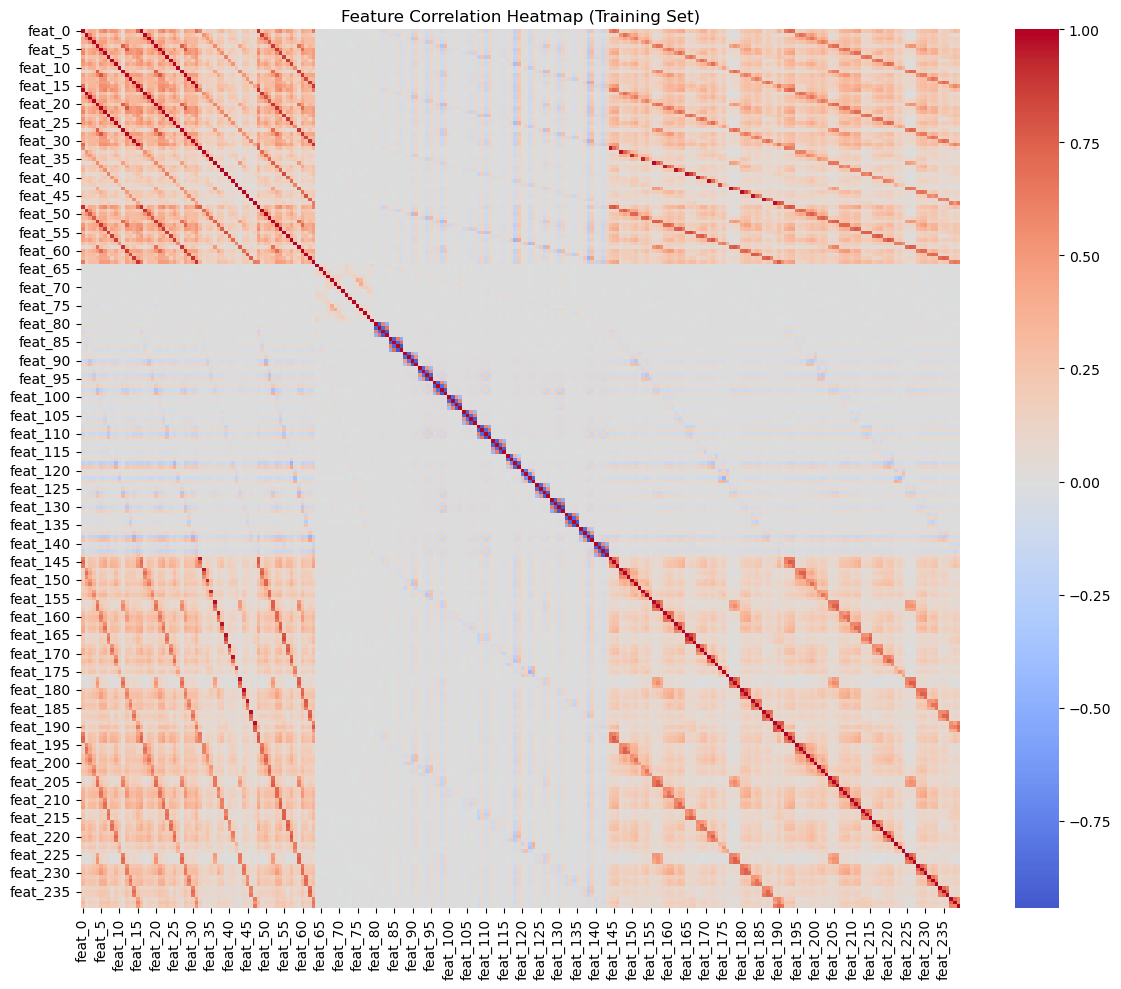

In [ ]:
import seaborn as sns
corr_matrix = pd.DataFrame(X_train, columns=[f'feat_{i}' for i in range(X_train.shape[1])]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Training Set)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "feature_correlation_heatmap.png"))


## 4. Gradient Boosting

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Normalize features (fit on train only)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_ctx)
X_val_z   = scaler.transform(X_val_ctx)
X_test_z  = scaler.transform(X_test_ctx)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import itertools
import os
import pandas as pd

# Base models
random_state = 42
base_models = {
    "HistGB": HistGradientBoostingRegressor(max_iter=100, learning_rate=0.05, max_depth=3, random_state=random_state),
    "XGB":    XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, n_jobs=1, random_state=random_state),
}

X_train_ctx = np.asarray(X_train_ctx)

# Train base models
trained_models = {}
for name, model in base_models.items():
    print(f"Training {name}...")
    multi_reg = MultiOutputRegressor(model, n_jobs=-1)
    multi_reg.fit(X_train_ctx, Y_train_w)
    trained_models[name] = multi_reg

Training HistGB...
Training XGB...


In [30]:
# Predictions
val_preds = {}
test_preds = {}
for name, model in trained_models.items():
    val_preds[name] = model.predict(X_val_ctx)
    test_preds[name] = model.predict(X_test_ctx)

In [31]:
# Averaging Ensemble
model_names = list(trained_models.keys())
val_stack = np.stack([val_preds[m] for m in model_names], axis=0)
test_stack = np.stack([test_preds[m] for m in model_names], axis=0)
Y_val_pred_avg = np.mean(val_stack, axis=0)
Y_test_pred_avg = np.mean(test_stack, axis=0)


In [33]:
from sklearn.linear_model import LinearRegression

# Stacking ensemble with one meta-model per joint
n_outputs = Y_val_w.shape[1]
meta_models = []  # List to store joint-wise regressors
Y_test_pred_stack_per_joint = np.zeros_like(Y_test_w)

# For each joint, train a meta-model
for j in range(n_outputs):
    # Build meta features: predictions of base models for this joint only
    meta_X_val_j = np.column_stack([val_preds[m][:, j] for m in model_names])
    meta_y_val_j = Y_val_w[:, j]

    # Train meta-learner
    meta_reg = LinearRegression()
    meta_reg.fit(meta_X_val_j, meta_y_val_j)
    meta_models.append(meta_reg)

    # Predict on test
    meta_X_test_j = np.column_stack([test_preds[m][:, j] for m in model_names])
    Y_test_pred_stack_per_joint[:, j] = meta_reg.predict(meta_X_test_j)
    
Y_test_pred_final = Y_test_pred_stack_per_joint

In [41]:
# Smoothing
alpha = 0.02
Y_test_pred_smooth = np.zeros_like(Y_test_pred_final)
Y_test_pred_smooth[0] = Y_test_pred_final[0]
for t in range(1, Y_test_pred_final.shape[0]):
    Y_test_pred_smooth[t] = alpha * Y_test_pred_final[t] + (1 - alpha) * Y_test_pred_smooth[t-1]

# Clamp to joint limits
joint_mins = glove_mov.min(axis=0)
joint_maxs = glove_mov.max(axis=0)
Y_test_pred_smooth_clamped = np.clip(Y_test_pred_smooth, joint_mins, joint_maxs)

In [42]:
computed_best_params = {
    "HistGB": {
        "max_depth": 3,
        "learning_rate": 0.05,
        "max_iter": 100
    },
    "XGB": {
        "max_depth": 3,
        "learning_rate": 0.05,
        "n_estimators": 100
    }
}

In [43]:
# Hyperparameter tuning grid (FIXED: missing comma before "CatBoost" block)
param_grid = {
    "HistGB": {
        "max_depth": [3, 5],
        "learning_rate": [0.05, 0.1],
        "max_iter": [100, 300]
    },
    "XGB": {
        "max_depth": [3, 5],
        "learning_rate": [0.05, 0.1],
        "n_estimators": [100, 300]
    }
}

# Grid search
best_params = {}
best_val_rmse = {}
val_predictions = {}

if computed_best_params is None:
    for name, grid in param_grid.items():
        print(f"\nTuning hyperparameters for {name}...")
        best_rmse = float('inf')
        best_param = None
        keys, values = zip(*grid.items())
        for combo in itertools.product(*values):
            params = dict(zip(keys, combo))
            if name == "HistGB":
                model = HistGradientBoostingRegressor(random_state=random_state, **params)
            elif name == "XGB":
                model = XGBRegressor(n_jobs=1, random_state=random_state, **params)
            multi_reg = MultiOutputRegressor(model, n_jobs=-1)
            multi_reg.fit(X_train_ctx, Y_train_w)
            Y_val_pred = multi_reg.predict(X_val_ctx)
            rmses = np.sqrt(mean_squared_error(Y_val_w, Y_val_pred, multioutput="raw_values"))
            mean_rmse = rmses.mean()
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_param = params
                val_predictions[name] = Y_val_pred  # Save best prediction
        best_params[name] = best_param
        best_val_rmse[name] = best_rmse
        print(f"Best params for {name}: {best_param} (Val RMSE = {best_rmse:.3f})")
else:
    print("Using predefined best hyperparameters.")
    best_params = computed_best_params
    for name, params in best_params.items():
        print(f"Training {name} with predefined parameters: {params}")
        if name == "HistGB":
            model = HistGradientBoostingRegressor(random_state=random_state, **params)
        elif name == "XGB":
            model = XGBRegressor(n_jobs=1, random_state=random_state, **params)
        multi_reg = MultiOutputRegressor(model, n_jobs=-1)
        multi_reg.fit(X_train_ctx, Y_train_w)
        Y_val_pred = multi_reg.predict(X_val_ctx)
        val_predictions[name] = Y_val_pred
        rmses = np.sqrt(mean_squared_error(Y_val_w, Y_val_pred, multioutput="raw_values"))
        best_val_rmse[name] = rmses.mean()


Using predefined best hyperparameters.
Training HistGB with predefined parameters: {'max_depth': 3, 'learning_rate': 0.05, 'max_iter': 100}
Training XGB with predefined parameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100}


10 min environ pour HistGB :
Best params for HistGB: {'max_depth': 3, 'learning_rate': 0.05, 'max_iter': 100} (Val RMSE = 11.025)
16min environ pour XGB
Best params for XGB: {'max_depth': 3, 'learning_rate': 0.05, 'max_iter': 100} (Val RMSE = 10.991)

### Test evaluation

In [44]:
import pandas as pd

rmse_val  = np.sqrt(mean_squared_error(Y_val_w,  Y_val_pred,  multioutput="raw_values"))
rmse_test = np.sqrt(mean_squared_error(Y_test_w, Y_test_pred_smooth_clamped, multioutput="raw_values"))
mae_test  = mean_absolute_error(Y_test_w, Y_test_pred_smooth_clamped, multioutput="raw_values")
r2_test   = r2_score(Y_test_w, Y_test_pred_smooth_clamped, multioutput="raw_values")


df = pd.DataFrame({
    "joint_id": joint_angles_used,
    "rmse_val": rmse_val,
    "rmse_test": rmse_test,
    "mae_test": mae_test,
    "r2_test": r2_test,
})

# Add mean row
df_mean = pd.DataFrame([{
    "joint_id": "MEAN",
    "rmse_val": rmse_val.mean(),
    "rmse_test": rmse_test.mean(),
    "mae_test": mae_test.mean(),
    "r2_test": r2_test.mean(),
}])
df = pd.concat([df, df_mean], ignore_index=True)

out_csv = os.path.join(out_dir, "part3_separate_models_metrics.csv")
df.to_csv(out_csv, index=False)
print("Saved metrics to:", out_csv)
print(df)

Saved metrics to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_separate_models_metrics.csv
  joint_id   rmse_val  rmse_test   mae_test   r2_test
0        3  11.627123   4.229938   3.436674  0.324659
1        6  31.721856  21.183146  19.156792  0.051954
2        8   3.618503   2.206791   1.746526 -0.190719
3       11   5.197923   8.174835   6.651024 -1.404715
4       14   2.790433   4.782342   3.713806 -1.369250
5     MEAN  10.991168   8.115410   6.940965 -0.517614


### Plot predictions

Saved plot to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_ensemble_true_vs_pred_smoothed.png


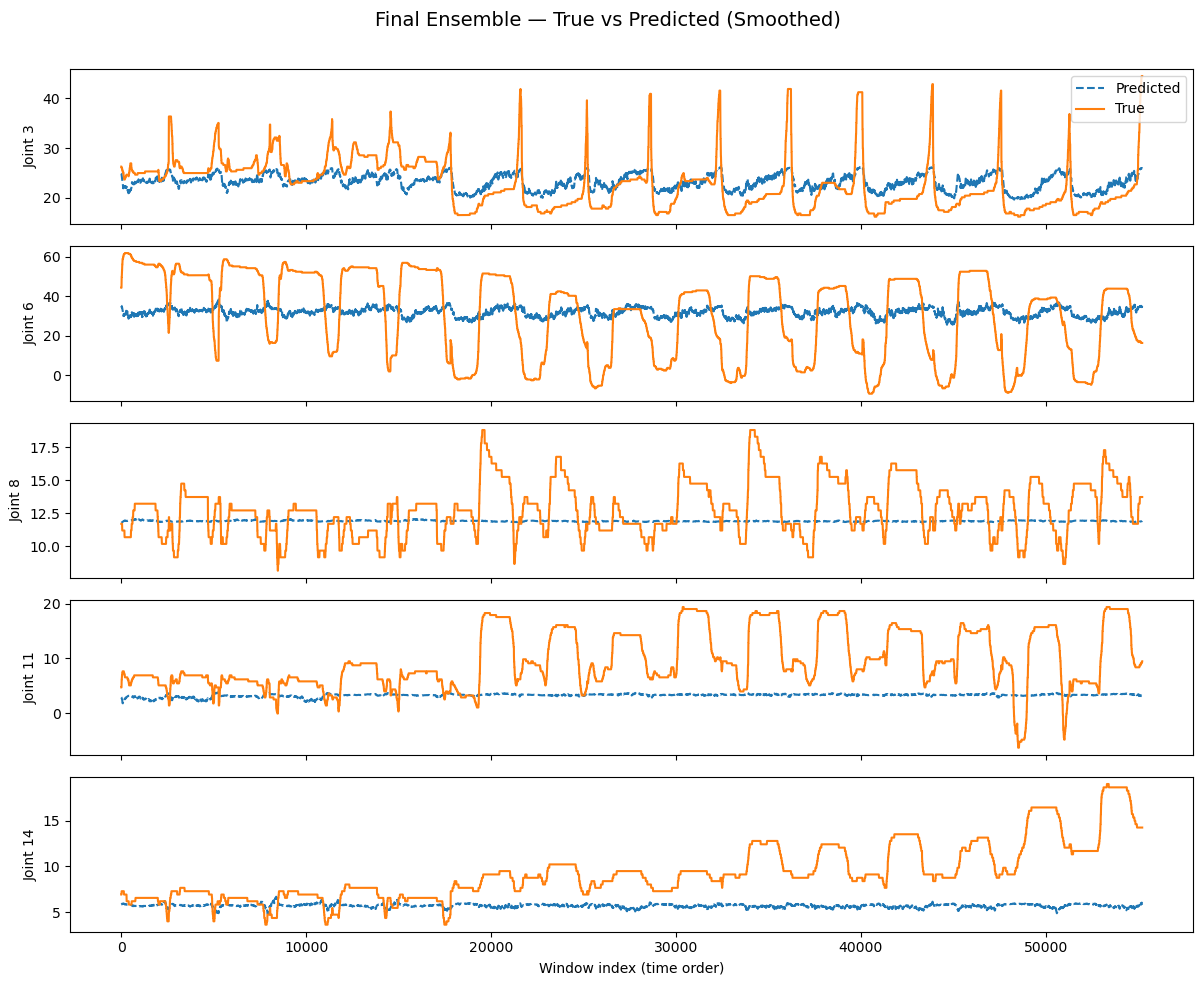

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(joint_angles_used), 1, figsize=(12, 10), sharex=True)
fig.suptitle("Final Ensemble — True vs Predicted (Smoothed)", fontsize=14)


for k, joint_id in enumerate(joint_angles_used):
    ax = axes[k]
    ax.plot(Y_test_pred_smooth_clamped[:, k], linestyle="--", label="Predicted")
    ax.plot(Y_test_w[:, k], label="True")
    ax.set_ylabel(f"Joint {joint_id}")
    if k == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Window index (time order)")
fig.tight_layout(rect=[0, 0, 1, 0.97])

fig_path = os.path.join(out_dir, "part3_ensemble_true_vs_pred_smoothed.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved plot to:", fig_path)


Saved smoothing effect plot to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_smoothing_effect.png


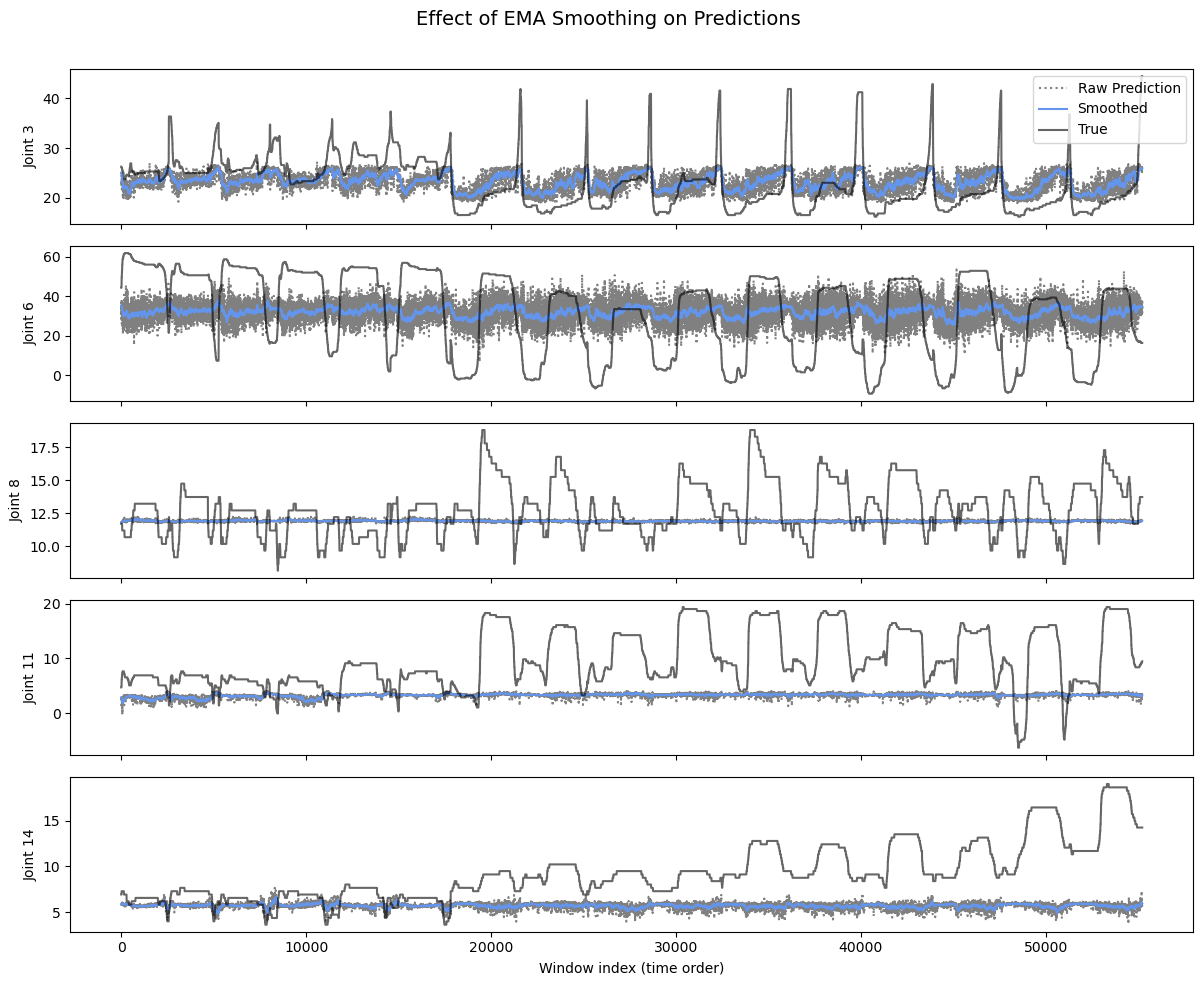

In [46]:
fig, axes = plt.subplots(len(joint_angles_used), 1, figsize=(12, 10), sharex=True)
fig.suptitle("Effect of EMA Smoothing on Predictions", fontsize=14)

for k, joint_id in enumerate(joint_angles_used):
    ax = axes[k]
    ax.plot(Y_test_pred_final[:, k], linestyle=":", color="gray", label="Raw Prediction")
    ax.plot(Y_test_pred_smooth_clamped[:, k], linestyle="-", color="cornflowerblue", label="Smoothed")
    ax.plot(Y_test_w[:, k], color="black", alpha=0.6, label="True")
    ax.set_ylabel(f"Joint {joint_id}")
    if k == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Window index (time order)")
fig.tight_layout(rect=[0, 0, 1, 0.97])

smooth_path = os.path.join(out_dir, "part3_smoothing_effect.png")
fig.savefig(smooth_path, dpi=200, bbox_inches="tight")
print(f"Saved smoothing effect plot to: {smooth_path}")


Saved residual plot to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_residuals_per_joint.png


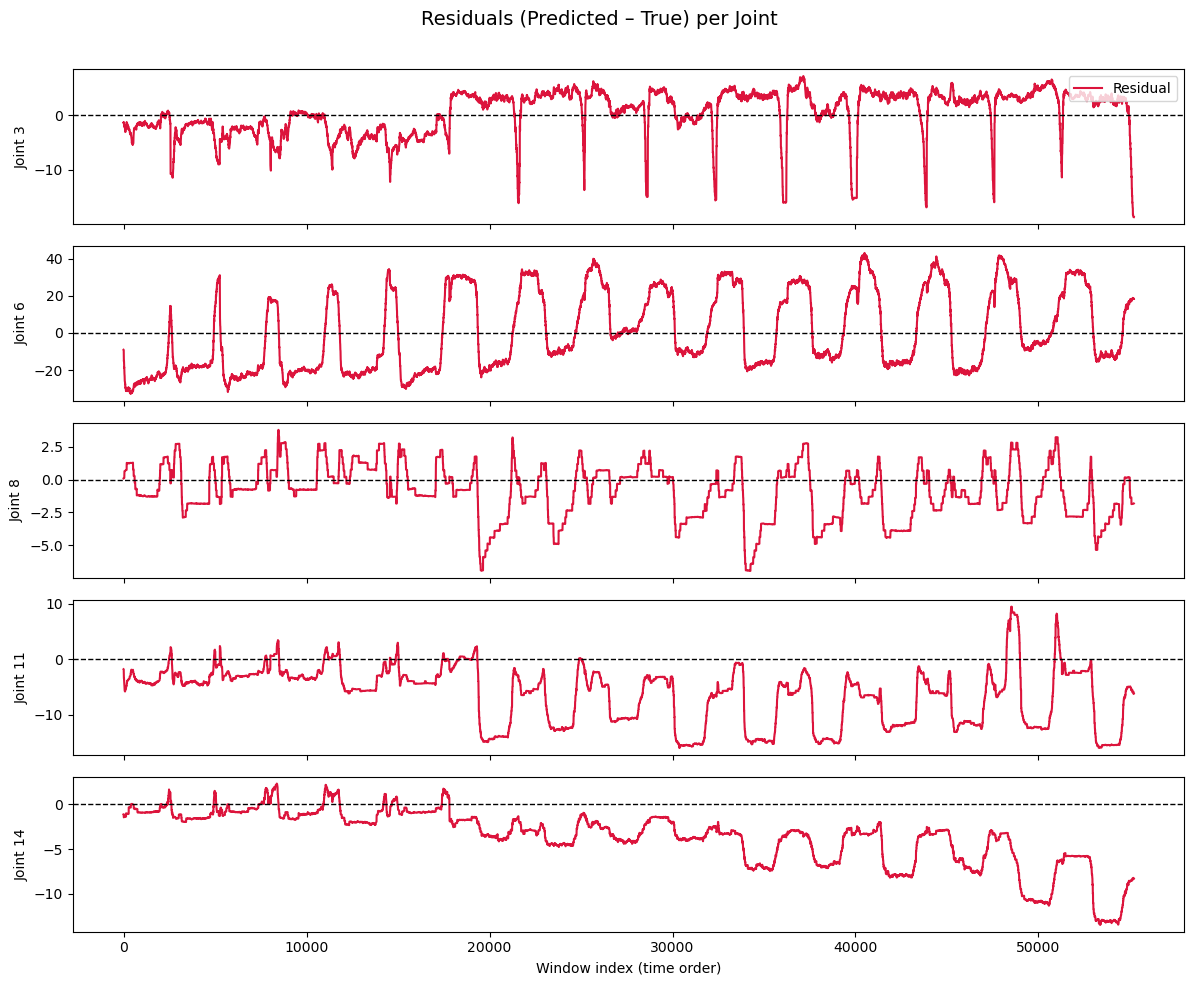

In [47]:
import matplotlib.pyplot as plt

# Residuals = predicted - actual
residuals = Y_test_pred_smooth_clamped - Y_test_w

fig, axes = plt.subplots(len(joint_angles_used), 1, figsize=(12, 10), sharex=True)
fig.suptitle("Residuals (Predicted – True) per Joint", fontsize=14)

for k, joint_id in enumerate(joint_angles_used):
    ax = axes[k]
    ax.plot(residuals[:, k], color="crimson", label="Residual")
    ax.axhline(0, linestyle="--", color="black", linewidth=1)
    ax.set_ylabel(f"Joint {joint_id}")
    if k == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Window index (time order)")
fig.tight_layout(rect=[0, 0, 1, 0.97])

resid_path = os.path.join(out_dir, "part3_residuals_per_joint.png")
fig.savefig(resid_path, dpi=200, bbox_inches="tight")
print(f"Saved residual plot to: {resid_path}")


### Stability plot (RMSE per joint)

Saved RMSE-per-joint plot to: /home/johhan/github/NX-421_Miniproject_2/Results/Part3/part3_rmse_per_joint.png


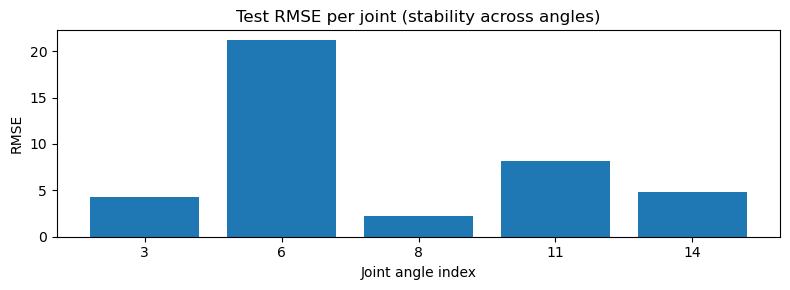

In [48]:
rmse_test_per_joint = np.sqrt(mean_squared_error(Y_test_w, Y_test_pred_smooth_clamped, 
                                                 multioutput="raw_values"))

plt.close("all")
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar([str(j) for j in joint_angles_used], rmse_test_per_joint)
ax.set_title("Test RMSE per joint (stability across angles)")
ax.set_xlabel("Joint angle index")
ax.set_ylabel("RMSE")
fig.tight_layout()
bar_path = os.path.join(out_dir, "part3_rmse_per_joint.png")
fig.savefig(bar_path, dpi=200, bbox_inches="tight")
print(f"Saved RMSE-per-joint plot to: {bar_path}")